# Simulating Time Window Sampling Using Reddit Submissions from Jan 2020
## Last updated Feb 11, 2021

*Current version is a bit half-baked. This is just being committed to check-in make it easy to
share several relevant figures. Remove this message after clean-up + running notebook from the top.*

The main content of interest is the violin plot and bar plot below
showing the distribution of sample means for different samples.

In [6]:
import pandas as pd
import numpy as np
import datetime
import asyncpraw
import os
import time
import seaborn as sns
from helpers import generate_windows
import random

## File Loading

Let's load jan2020 zst file (downloaded from https://files.pushshift.io/)

We'll use the zreader code, also from pushshift (https://github.com/pushshift/zreader)!

Note that we're running the current version on deepnote, which has limited RAM.
We can't load all of Jan 2020 at once, so we'll limit our first set of simulations
to Jan 1,2,3, and 4 (i.e. using Jan 5 00:00 as the `before` parameter).

We'll also avoid loading unnecessary columns.

In [7]:
filename = '/datasets/bucket/jan2020/RS_2020-01.zst'

In [8]:
import ujson as json
import zstandard as zstd

class Zreader:

    def __init__(self, file, chunk_size=16384):
        '''Init method'''
        self.fh = open(file,'rb')
        self.chunk_size = chunk_size
        self.dctx = zstd.ZstdDecompressor()
        self.reader = self.dctx.stream_reader(self.fh)
        self.buffer = ''


    def readlines(self):
        '''Generator method that creates an iterator for each line of JSON'''
        while True:
            chunk = self.reader.read(self.chunk_size).decode()
            if not chunk:
                break
            lines = (self.buffer + chunk).split("\n")

            for line in lines[:-1]:
                yield line

            self.buffer = lines[-1]

In [9]:
# Adjust chunk_size as necessary -- defaults to 16,384 if not specified
reader = Zreader(filename, chunk_size=8192)

# Read each line from the reader
count = 0
cols = ['created_utc', 'subreddit', 'score']
before = datetime.datetime(2020, 1, 5)

rows = []
for line in reader.readlines():
    obj = json.loads(line)
    ts = obj['created_utc']
    if datetime.datetime.fromtimestamp(ts) < before:
        rows.append({k: obj[k] for k in cols})
    else:
        break
    count +=1 
df = pd.DataFrame(rows)
df['dt'] = df.created_utc.apply(datetime.datetime.fromtimestamp)
print(len(df))

2829419


Check out descriptive stats for the days we loaded.

In [10]:
df.describe()

,created_utc,score
count,2.829419e+06,2.829419e+06
mean,1.578015e+09,9.539031e+01
std,9.853726e+04,1.279870e+03
min,1.577837e+09,0.000000e+00
25%,1.577929e+09,1.000000e+00
50%,1.578014e+09,2.000000e+00
75%,1.578096e+09,1.300000e+01
max,1.578182e+09,1.705420e+05


## Time Window Sample

Here, we'll compare how "time window sampling"
(randomly select x% of y-second long time windows and get all posts from within said windows)
compares to true random sampling.

In [7]:
start_dt = datetime.datetime(2020, 1, 1)
end_dt = before

In [8]:
df.subreddit.value_counts()

TalkativePeople    78231
AskReddit          65724
memes              53514
dankmemes          32111
teenagers          28081
                   ...  
getvectored            1
OnePieceR34            1
FortniteTrash          1
FromFirstToLast        1
TrainVideos            1
Name: subreddit, Length: 139411, dtype: int64

We're going to look at how well our sample
estimates:
* post count
* mean score
* post count for popular subreddit(s)
* mean score of posts within popular subreddit(s)

the value of `k` below determines how many difference popular (deteremined by post score)
subreddits to look at. 

In [10]:
k = 2
top_by_score = df.groupby('subreddit').score.sum().sort_values(ascending=False)[:k]
top_subs = top_by_score.index
top_agg = df[df.subreddit.isin(top_subs)].groupby('subreddit').score.agg(['count', 'mean'])
top_agg

,count,mean
subreddit,,
dankmemes,32111,493.965432
memes,53514,392.271891


In [23]:
rows = []

fracs = [
    0.01,
    0.02,
    0.04,
    0.08,
    0.16
]
window_secs = [
    #15,
    30, 
    60,
    120,
    240,
    #480
]

seeds = 50
for frac in fracs:
    estimates = {
        'total_mean': [],
        'total_count': [],
    }
    for seed in range(0, seeds):
        samp = df.sample(frac=frac, random_state=seed)
        estimates['total_mean'].append(samp.score.mean())
        for sub in top_subs:
            subset = samp[samp.subreddit == sub]
            key = f'{sub}_mean'
            if key not in estimates:
                estimates[key] = []
            estimates[key].append(subset.score.mean())

            key = f'{sub}_count'
            if key not in estimates:
                estimates[key] = []
            estimates[key].append(len(subset) / frac)
    row = {
        'frac': frac,
        'window_sec': 0
    }
    for k, v in estimates.items():
        row[k] = v
    rows.append(row)

    for window_sec in window_secs:
        print(frac, window_sec)
        window_size = datetime.timedelta(seconds=window_sec+0.01)
        windows = generate_windows(start_dt, end_dt, window_size)

        estimates = {
            'total_mean': [],
            'total_count': [],
        }
        for seed in range(0,seeds):
            random.seed(seed)
            n = int(len(windows) * frac)
            chosen_windows = random.sample(windows, n)
            score = []
            sub_to_scores = {}
            for i_window, window in enumerate(chosen_windows):
                subset = df[
                    (df.dt > window[0]) &
                    (df.dt < window[1])
                ]
                score += list(subset.score)
                for sub in top_subs:
                    if sub not in sub_to_scores:
                        sub_to_scores[sub] = []

                    sub_to_scores[sub] += list(subset[subset.subreddit == sub].score)
            estimates['total_mean'].append(np.mean(score))
            estimates['total_count'].append(len(score) / frac)
            for sub, scores in sub_to_scores.items():
                key1 = f'{sub}_mean'
                key2 = f'{sub}_count'
                if key1 not in estimates:
                    estimates[key1] = []
                if key2 not in estimates:
                    estimates[key2] = []
                estimates[key1].append(np.mean(scores))
                estimates[key2].append(len(scores) / frac)
        row = {
            'frac': frac,
            'window_sec': window_sec,
        }
        for k, v in estimates.items():
            row[k] = v
        rows.append(row)

results = pd.DataFrame(rows)

results.to_csv('results.csv', index=False)


0.01 30
0.01 60
0.01 120
0.01 240
0.02 30
0.02 60
0.02 120
0.02 240
0.04 30
0.04 60
0.04 120
0.04 240
0.08 30
0.08 60
0.08 120
0.08 240
0.16 30
0.16 60
0.16 120
0.16 240


In [41]:
results = pd.read_csv('results.csv')
#results['total_mean'] = results['total_mean'].apply(list)

In [40]:
results

,Unnamed: 0,frac,window_sec,total_mean,total_count,memes_mean,memes_count,dankmemes_mean,dankmemes_count
0,0,0.01,NaN,"[[, 9, 9, ., 9, 7, 4, 4, 4, 6, 8, 7, 9, 1, 9, ...",[],"[532.7719594594595, 504.5954631379962, 351.053...","[59200.0, 52900.0, 54400.0, 54200.0, 50400.0, ...","[305.9966216216216, 317.8290598290598, 550.417...","[29600.0, 35100.0, 33800.0, 34600.0, 32300.0, ..."
1,1,0.01,30.0,"[[, 1, 1, 3, ., 7, 5, 7, 0, 0, 0, 3, 5, 6, 2, ...","[2807000.0, 2829500.0, 2928800.0, 2701400.0, 2...","[269.3531669865643, 210.96703296703296, 382.19...","[52100.0, 54600.0, 56000.0, 58400.0, 49600.0, ...","[607.9003436426117, 779.0922190201729, 336.142...","[29100.0, 34700.0, 35800.0, 33600.0, 30000.0, ..."
2,2,0.01,60.0,"[[, 8, 8, ., 1, 8, 4, 1, 6, 4, 5, 4, 3, 1, 3, ...","[2747000.0, 2751200.0, 2843300.0, 2727900.0, 2...","[233.42162162162163, 273.56607142857143, 261.6...","[55500.0, 56000.0, 53000.0, 57300.0, 47300.0, ...","[196.28662420382165, 951.3206896551724, 321.30...","[31400.0, 29000.0, 31100.0, 34000.0, 26300.0, ..."
3,3,0.01,120.0,"[[, 9, 9, ., 8, 9, 1, 4, 7, 5, 8, 9, 9, 3, 3, ...","[2813200.0, 2636500.0, 2696100.0, 2682400.0, 2...","[190.94880546075086, 425.35, 213.3371868978805...","[58600.0, 50000.0, 51900.0, 57700.0, 44400.0, ...","[701.7258566978193, 934.984076433121, 370.4868...","[32100.0, 31400.0, 30400.0, 38000.0, 24400.0, ..."
4,4,0.01,240.0,"[[, 9, 9, ., 5, 4, 3, 8, 5, 5, 9, 6, 1, 8, 8, ...","[2854800.0, 2753900.0, 2520100.0, 2463700.0, 2...","[299.72401433691755, 299.4625228519196, 230.67...","[55800.0, 54700.0, 46100.0, 51100.0, 43500.0, ...","[321.58456973293767, 1113.5480225988701, 570.1...","[33700.0, 35400.0, 26900.0, 32400.0, 24800.0, ..."
5,5,0.02,NaN,"[[, 9, 7, ., 0, 7, 3, 5, 4, 9, 1, 6, 2, 3, 6, ...",[],"[492.45099818511795, 413.5725734639359, 312.25...","[55100.0, 56150.0, 52150.0, 56950.0, 51500.0, ...","[384.4991680532446, 347.1424460431655, 588.869...","[30050.0, 34750.0, 33300.0, 33500.0, 33650.0, ..."
6,6,0.02,30.0,"[[, 1, 1, 2, ., 7, 4, 8, 8, 5, 4, 2, 7, 8, 5, ...","[2793000.0, 2835950.0, 2813800.0, 2761150.0, 2...","[305.0509433962264, 282.0458553791887, 532.067...","[53000.0, 56700.0, 52050.0, 56350.0, 48250.0, ...","[585.0797962648556, 550.1281669150521, 454.946...","[29450.0, 33550.0, 32800.0, 33850.0, 30850.0, ..."
7,7,0.02,60.0,"[[, 9, 8, ., 4, 2, 6, 4, 5, 3, 8, 8, 1, 5, 2, ...","[2772750.0, 2847150.0, 2927800.0, 2755250.0, 2...","[283.9644859813084, 267.26683937823833, 258.19...","[53500.0, 57900.0, 60100.0, 55400.0, 48400.0, ...","[426.71879936808847, 873.8277511961722, 436.64...","[31650.0, 31350.0, 33400.0, 31150.0, 28500.0, ..."
8,8,0.02,120.0,"[[, 9, 3, ., 3, 9, 0, 7, 9, 6, 5, 1, 7, 6, 0, ...","[2773950.0, 2740750.0, 2847750.0, 2683500.0, 2...","[175.81546572934974, 312.3293357933579, 266.54...","[56900.0, 54200.0, 52800.0, 56750.0, 47500.0, ...","[466.1691616766467, 645.3220338983051, 300.824...","[33400.0, 32450.0, 32150.0, 35300.0, 26900.0, ..."
9,9,0.02,240.0,"[[, 1, 0, 4, ., 8, 0, 3, 9, 3, 8, 4, 9, 4, 7, ...","[2780250.0, 2625000.0, 2721500.0, 2685100.0, 2...","[382.55845323741005, 361.9478260869565, 285.32...","[55600.0, 51750.0, 53900.0, 56800.0, 45650.0, ...","[316.09327217125383, 763.197247706422, 390.739...","[32700.0, 32700.0, 31150.0, 35200.0, 24900.0, ..."


In [30]:
results.columns

Index(['Unnamed: 0', 'frac', 'window_sec', 'total_mean', 'total_count',
       'memes_mean', 'memes_count', 'dankmemes_mean', 'dankmemes_count'],
      dtype='object')

In [31]:
cols = [x for x in results.columns if 'mean' in x]
cols

['total_mean', 'memes_mean', 'dankmemes_mean']

In [32]:
tru_mean = {
    'total_mean': df.score.mean(),
    'memes_mean': df[df.subreddit == 'memes'].score.mean(),
    'dankmemes_mean': df[df.subreddit == 'dankmemes'].score.mean()
}
tru_count = {
    'total_count': len(df),
    'memes_count': len(df[df.subreddit == 'memes'])
}

In [37]:
for x in results.total_mean:

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [34]:
for col in cols:
    print(col)
    # try:
    #     sub = col.split('_')[0]
    #     print(sub)
    # except Exception as e:
    #     pass

    mean_col = f'{col}_mean'
    results[mean_col] = results[col].apply(np.mean)

    std_col = f'{col}_std'
    results[std_col] = results[col].apply(np.std)

    rmse_col = f'{col}_rmse'
    if 'mean' in col:
        tru = tru_mean[col]
    elif 'count' in col:
        continue
        tru = tru_count[col]
    results[rmse_col] = results[col].apply(
        lambda x: x - tru).apply(
            lambda x: x**2).apply(np.mean).apply(
                np.sqrt)
    # print(results[['frac', 'window_sec', mean_col, rmse_col]], '\n')


total_mean


TypeError: cannot perform reduce with flexible type

## Plotting of Sample Means for `total_score` (i.e. the mean score of all posts)

### Violin Plot

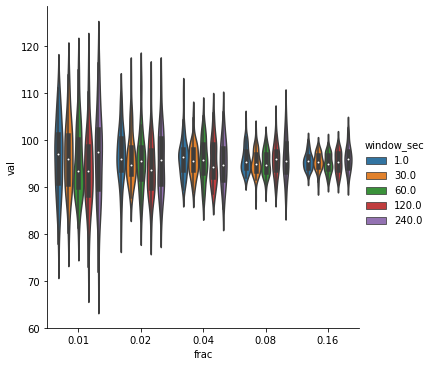

In [38]:
longform = []
for i, row in results.iterrows():
    for val in row.total_mean:
        longform.append({'frac': row.frac, 'window_sec': row.window_sec, 'val': val})
longform_df = pd.DataFrame(longform)
#longform_df
sns.catplot(data=longform_df, x='frac', y='val', hue='window_sec', kind='violin')


### Bar plots with 99% bootsrapped CIs

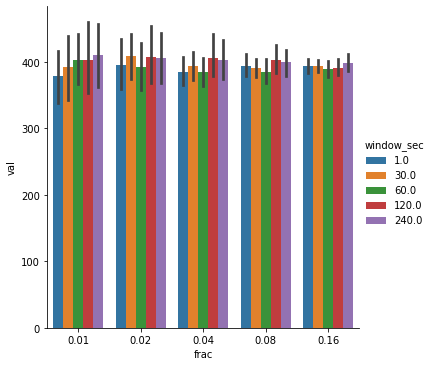

In [42]:
sns.catplot(data=longform_df, x='frac', y='val', hue='window_sec', kind='bar', ci=99)


In [1]:
# TODO: product violin plot for specific subreddits as well!

longform = []
for i, row in results.iterrows():
    for val in row.memes_mean:
        longform.append({'frac': row.frac, 'window_sec': row.window_sec, 'val': val, 'sub': 'memes'})
    for val in row.dankmemes_mean:
        longform.append({'frac': row.frac, 'window_sec': row.window_sec, 'val': val, 'sub': 'dankmems'})
longform_df = pd.DataFrame(longform)
#longform_df
sns.catplot(data=longform_df, x='frac', y='val', hue='window_sec', kind='violin', row='sub')


# Root Mean Squared Errors

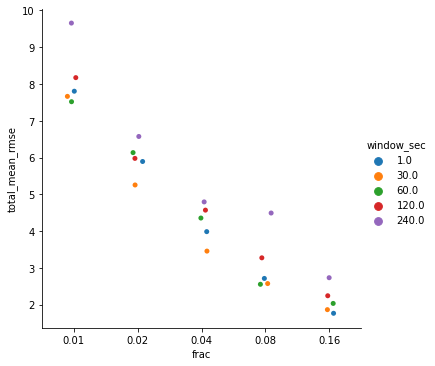

In [45]:
sns.catplot(data=results, x='frac', y='total_mean_rmse', hue='window_sec')

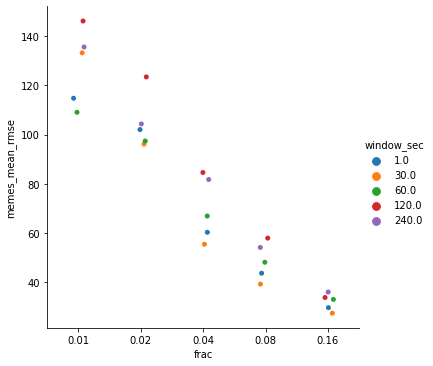

In [46]:
sns.catplot(data=results, x='frac', y='memes_mean_rmse', hue='window_sec')

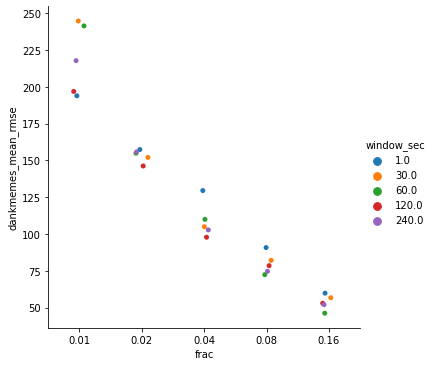

In [47]:
sns.catplot(data=results, x='frac', y='dankmemes_mean_rmse', hue='window_sec')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9d8dd8e7-abf2-4721-84cd-03779d208ef5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>